Dependencies

In [8]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [9]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

Load the Dataset

In [10]:
ds = tfds.load("fashion_mnist", split="train")

In [11]:
ds

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [12]:
ds.as_numpy_iterator().next()['label']

2

Visualize the Data 

In [13]:
import numpy as np
data_iterator = ds.as_numpy_iterator()

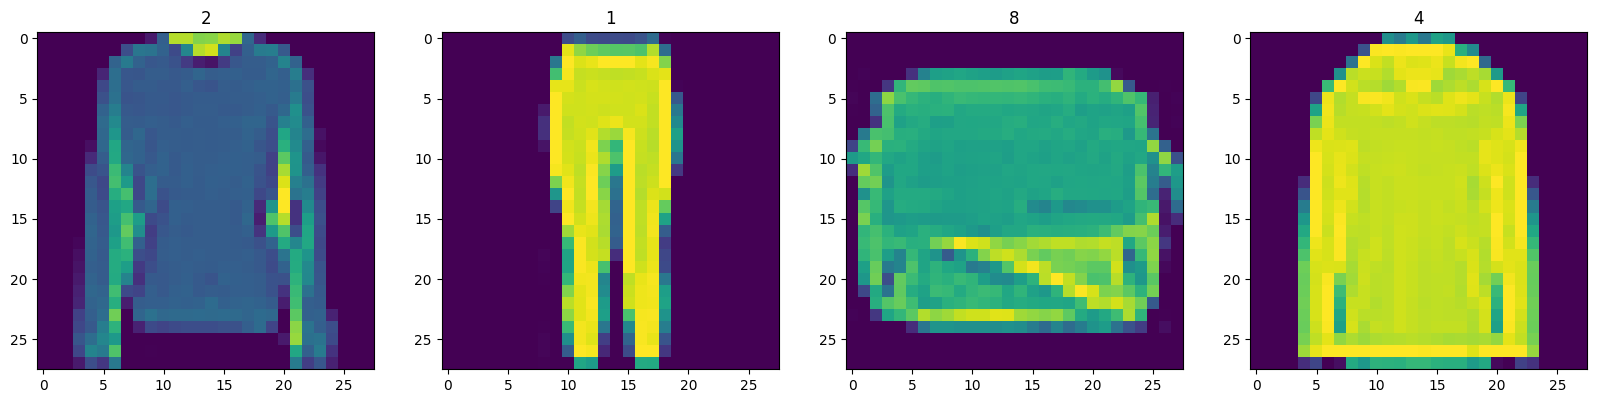

In [14]:
fig, ax = plt.subplots(ncols = 4, figsize = (20, 20))
for idx in range(4):
    batch = data_iterator.next()
    ax[idx].imshow(np.squeeze(batch['image']))
    ax[idx].title.set_text(batch['label'])

In [15]:
def scale_im(data):
    image = data['image']
    return image/255

Data Pipeline 

In [16]:
ds = ds.map(scale_im)
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)

In [17]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

Build The Generator Neural Network

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [37]:
def build_generator():
    model = Sequential()
    model.add(Dense(7*7*128, input_dim = 128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding = "same"))
    model.add(LeakyReLU(0.2))
    
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding = "same"))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(128, 4, padding = "same"))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(128, 4, padding = "same"))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(1, 4, padding = "same", activation = "sigmoid"))
    
    return model

In [38]:
Generator = build_generator()
Generator.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_29 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_8 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_11 (UpSampli  (None, 14, 14, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_24 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

1/1 [==============================] - 0s 286ms/step


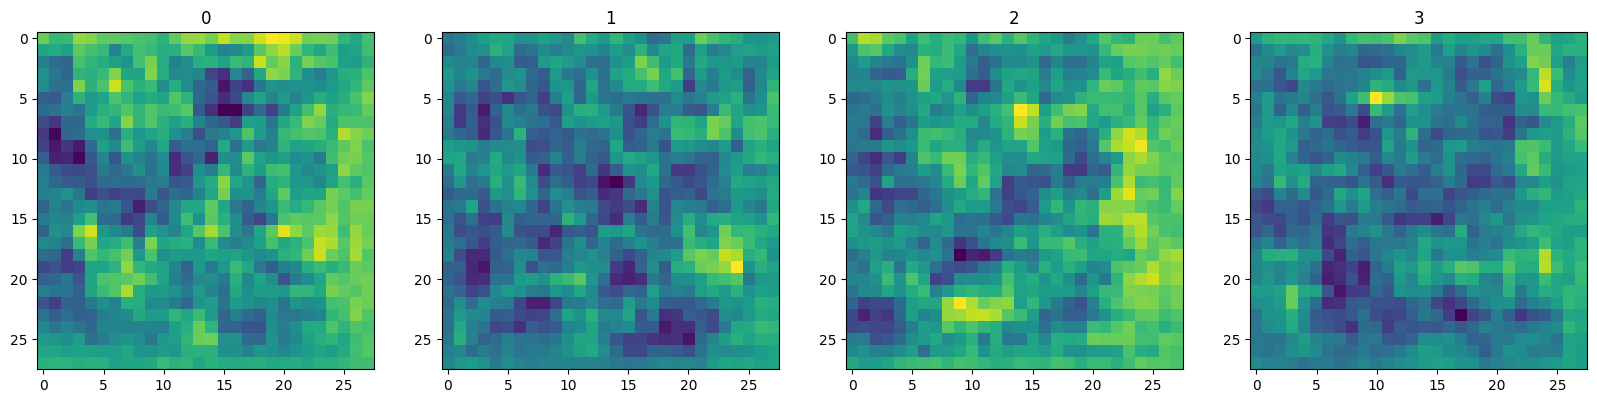

In [39]:
img = Generator.predict(np.random.randn(4, 128, 1))
fig, ax = plt.subplots(ncols = 4, figsize = (20, 20))
for idx, img in enumerate(img):
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)

Build the Discriminator Neural Network

In [40]:
def build_discriminator():
    model = Sequential()
    
    model.add(Conv2D(32, 5, input_shape = (28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    
    
    return model

In [41]:
Discriminator = build_discriminator()

In [42]:
Discriminator.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_34 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
Total params: 832 (3.25 KB)
Trainable params: 832 (3.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
